In [1]:
import requests
import ephem
from dateutil.parser import parse as dateparser
import datetime
import sys, os, re
import pymongo
import math

from satellite_utils import *

#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
current_time = ephem.now()
current_time

43485.515914351854

In [3]:
dbx = dbConnect()

In [4]:
_ = dbx.tle.find({'INTLDES': '16036A'}, {'_id':0, 'TLE_LINE0':1, 'TLE_LINE1':1, 'TLE_LINE2':1,}).sort([('EPOCH',-1)]).limit(1).next()
mentor7 = [str(_['TLE_LINE0']), str(_['TLE_LINE1']), str(_['TLE_LINE2']), ]
m7eph = ephem.readtle(*mentor7)
m7eph.compute()
m7eph.name

'Mentor 7'

In [5]:
_ = dbx.tle.find({'INTLDES': '16041A'}, {'_id':0, 'TLE_LINE0':1, 'TLE_LINE1':1, 'TLE_LINE2':1,}).sort([('EPOCH',-1)]).limit(1).next()
muos5 = [str(_['TLE_LINE0']), str(_['TLE_LINE1']), str(_['TLE_LINE2']), ]
m5eph = ephem.readtle(*muos5)
m5eph.compute()
m5eph.name

'0 MUOS 5'

In [10]:
dbx.tle.count_documents({'INTLDES': '16041A'})

76

In [13]:
e = ''
def sats_visible_from_observer(dbh, observer):
    global e
    min_per_day = 1432 # 23h52m
    tolerance_mins = 5
    min_elev = 2.5
    
    seen = set()

    selector = {'$and':[
        {'OBJECT_TYPE': 'PAYLOAD'},
        {'INCLINATION': {'$lte': 10.0, '$gte': 3.0}},
        # {'OBJECT_NAME': {'$regex': 'MUOS'}},
        {'EPOCH': {'$gte': days_ago(7)}},
        {'PERIOD': {'$lte':min_per_day + tolerance_mins}},
        {'PERIOD': {'$gte':min_per_day - tolerance_mins}},
        ]}

    projection = {
        '_id':0,
        'OBJECT_NAME': 1,
        'EPOCH': 1,
        'TLE_LINE0':1,
        'TLE_LINE1':1,
        'TLE_LINE2':1,
        'INCLINATION': 1,
        }

    res = dbx['tle'].count_documents(selector)
    print('found {} recent TLEs'.format(res))
    res = dbx['tle'].find(selector, projection).sort([('EPOCH',-1)]) # .limit(2)

    visible_sats = []
    n = 0
    for this_sat in res:
        this_sat = dict(this_sat)
        _tle = [str(this_sat.pop('TLE_LINE0', '')),
               str(this_sat.pop('TLE_LINE1', '')),
               str(this_sat.pop('TLE_LINE2', ''))]
        _eph = ephem.readtle(*_tle)
        _eph.compute(observer)
        this_sat['LON'] = math.degrees(float(_eph.sublong))
        this_sat['LAT'] = math.degrees(float(_eph.sublat))
        this_sat['ALT'] = math.degrees(float(_eph.alt))

        this_sat['VIS'] = True if this_sat['ALT'] >= min_elev else False
        
        num = _eph.catalog_number
        if this_sat['VIS'] and num not in seen: # or True:
            n += 1
            seen.add(num)
            print('{:24s} {}   Lon/Lat = ({:10.5f}, {:9.5f}) {:-5.2f} v={} ({})'.format(
                _eph.name.replace('0 ', ''),
                this_sat['EPOCH'],
                this_sat['LON'],
                this_sat['LAT'],
                this_sat['ALT'],
                this_sat['VIS'], n))
            visible_sats.append(this_sat)
    print('found {} visible TLEs'.format(len(visible_sats)))

    sat_df = pd.DataFrame(visible_sats)
    sat_df = sat_df.sort_values(by='LON')
    lats = sat_df['LAT'][:].values
    lons = sat_df['LON'][:].values
    names = sat_df['OBJECT_NAME'][:].values
    return {'lons': lons, 'lats':lats, 'names': names}, sat_df

sats, sat_df = sats_visible_from_observer(dbx, campbell_observer())

found 378 recent TLEs
NSTAR C                  2019-01-19 12:25:33.733000   Lon/Lat = ( 135.90253,  -2.13872)  2.82 v=True (1)
ASTRA 1D                 2019-01-19 11:25:30.954000   Lon/Lat = ( -73.05247,   1.36204)  7.07 v=True (2)
ASTRA 1H                 2019-01-19 11:24:38.193000   Lon/Lat = ( -75.04257,  -1.20049)  9.97 v=True (3)
ELEKTRO-L                2019-01-19 09:00:12.292000   Lon/Lat = (-178.21386,  -2.96893) 46.41 v=True (4)
UFO 8 (USA 138)          2019-01-19 08:25:42.687000   Lon/Lat = ( 171.43853,  -8.11323) 39.33 v=True (5)
SKYNET 1                 2019-01-19 07:49:57.125000   Lon/Lat = (-103.72864,   6.18221) 32.47 v=True (6)
NATO 2A                  2019-01-19 07:49:57.125000   Lon/Lat = (-103.71084,   6.79627) 32.03 v=True (7)
USA 167                  2019-01-19 04:52:58.055000   Lon/Lat = (-129.84706,  -5.13292) 62.48 v=True (8)
JCSAT 6                  2019-01-19 03:52:46.902000   Lon/Lat = ( 149.93317,  -1.24579) 15.39 v=True (9)
USA 169                  2019-01-

In [8]:
fill_color='#6666ff'
water_color='#6666ff'
land_color='#cc9966'
gray50='#808080'
lightgray='#cccccc'
lightpink='#ff4444'
# inspired by http://matplotlib.org/basemap/users/examples.html
# http://pandas.pydata.org/pandas-docs/stable/visualization.html
# http://pandas.pydata.org/pandas-docs/stable/10min.html
# http://www.stephaniehicks.com/learnPython/pages/modules_eda.html
# http://bebi103.caltech.edu/2015/tutorials/t0b_intro_to_jupyter_notebooks.html

/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


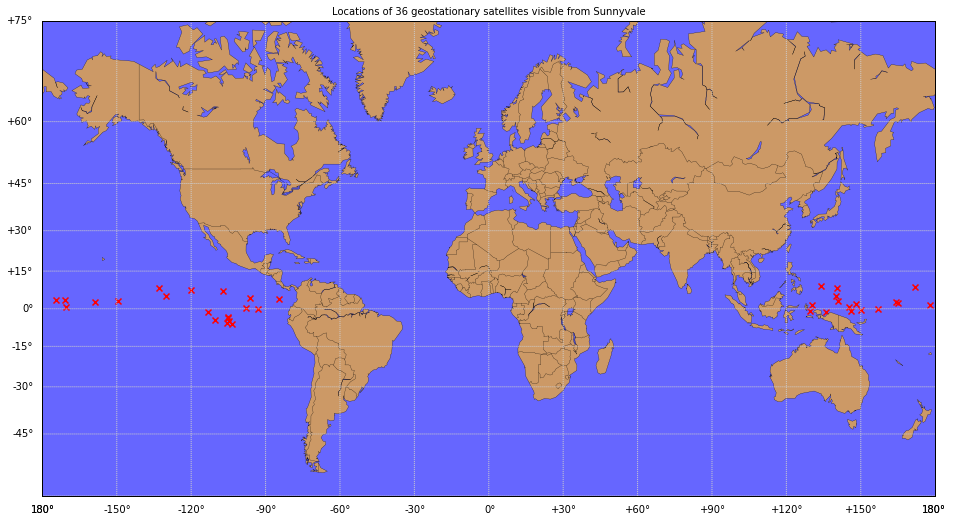

In [9]:
def plot_sats_visible_from_observer(lons, lats, names):
    plt.figure(figsize=(16,16))
    world = Basemap(projection='merc',
                llcrnrlat=-60,
                urcrnrlat=75,
                llcrnrlon=-180,
                urcrnrlon=180,
                #lat_ts=20,
                resolution='c')

    world.drawcoastlines(linewidth=0.25)
    world.drawcountries(linewidth=0.25)
    world.fillcontinents(color=land_color, lake_color=water_color)
    world.drawmapboundary(fill_color=water_color)

    world.drawparallels(np.arange(-90.,91.,15.), color=lightgray, labelstyle='+/-', labels=[1,0,0,0])
    world.drawmeridians(np.arange(-180.,181.,30.), color=lightgray, labelstyle='+/-', labels=[0,0,0,1])

    x, y = world(lons, lats)
    world.scatter(x, y, marker='x', color='red')
    plt.title('Locations of {} geostationary satellites visible from Sunnyvale'.format(len(names)), fontsize=10)
    plt.show()

plot_sats_visible_from_observer(sats['lons'], sats['lats'], sats['names'])

/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


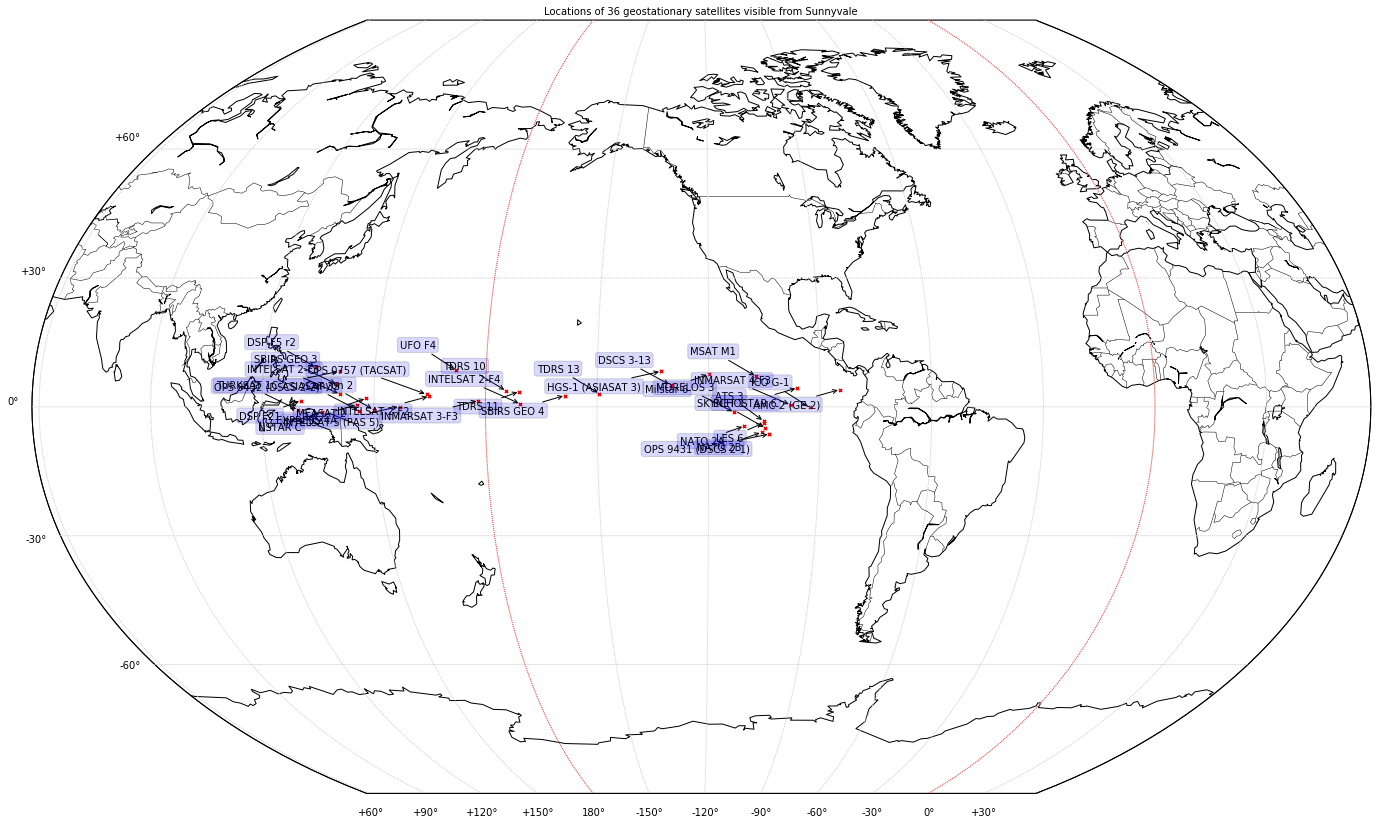

In [10]:
def plot_sats_visible_from_observer2(lons, lats, names):
    plt.figure(figsize=(24,24))

    # West coast of USA is about -122
    world = Basemap(projection='kav7',
                lon_0=-122,
                resolution='c')
    world.drawcoastlines()
    world.drawcountries()
    world.drawmapboundary()

    # draw parallels and meridians.
    world.drawparallels(np.arange(-90.,91.,30.), color=lightgray, labelstyle='+/-', labels=[1,0,0,0])
    world.drawmeridians(np.arange(-180.,181.,30.), color=lightgray, labelstyle='+/-', labels=[0,0,0,1])
    world.drawmeridians(np.arange(0.,181.,180.), color=lightpink)

    x, y = world(lons, lats)
    world.scatter(x, y, marker='x', color='red',s=10)

    sign = False
    for label, x, y in zip(names, lons, lats):
        x, y = world(x,y)
        sign = not sign
        plt.annotate(
            label, 
            xy = (x, y),
            xycoords = 'data',
            xytext = (-20, 20 if sign else -20),
            textcoords = 'offset points',
            ha = 'right',
            va = 'bottom',
            bbox = {'boxstyle': 'round,pad=0.25', 'fc': 'blue', 'alpha': 0.15},
            arrowprops = {'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0'})

    plt.title('Locations of {} geostationary satellites visible from Sunnyvale'.format(len(names)), fontsize=10)
    plt.show()

plot_sats_visible_from_observer2(sats['lons'], sats['lats'], sats['names'])

In [11]:
pd.set_option('display.max_rows', 150)
sat_df.sort_values(by='ALT', ascending=False)

,ALT,EPOCH,INCLINATION,LAT,LON,OBJECT_NAME,VIS
26,66.472986,2018-04-09 18:53:17.809,6.7305,3.075963,-149.381551,TDRS 13,True
32,65.790848,2018-04-05 18:59:02.228,6.3252,2.628139,-158.668136,SBIRS GEO 4,True
15,60.126627,2018-04-10 13:46:48.257,3.2146,0.670285,-170.602252,INTELSAT 2-F4,True
7,57.486246,2018-04-10 20:01:58.902,4.9936,3.561330,-170.925730,TDRS 11,True
24,54.514209,2018-04-10 02:12:33.586,5.5433,3.719543,-174.473685,TDRS 10,True
34,54.420253,2018-04-04 23:59:48.486,5.1389,5.062494,-130.224824,DSCS 3-13,True
19,53.547310,2018-04-10 11:08:37.872,8.3094,8.265664,-132.844720,HGS-1 (ASIASAT 3),True
1,49.414803,2018-04-11 08:08:58.271,4.0162,1.464334,178.090475,INMARSAT 3-F3,True
35,43.942589,2018-04-04 22:28:11.135,7.8404,7.613757,-119.976671,Milstar 6,True
27,42.593063,2018-04-09 16:15:24.422,6.0269,-1.260664,-113.161966,MORELOS 3,True


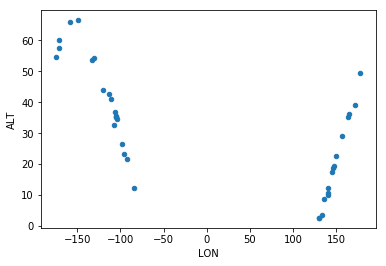

In [12]:
sat_df.plot(x='LON', y='ALT', kind='scatter')

In [14]:
def tle2sky(obs=sunnyvale_observer(), eph=None, tle=None, current_time=ephem.now()):
    if eph is None and tle is None:
        raise ValueError('at least one of ephemeris object or TLE must be given')
    if eph is None:
        if type(tle) is str:
            tle = tle.split('\n')
        eph = ephem.readtle(*tle)
    obs.epoch = current_time
    print('Calculating position at {}'.format(str(current_time.datetime())))
    eph.compute(obs)
    
    lat = math.degrees(float(eph.sublat))
    lon = math.degrees(float(eph.sublong))
    alt = math.degrees(float(eph.alt))
    w = ['', '']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,24))

    ax[0].set_title('Earth view from {}\n{} / {}'.format(eph.name, lat, lon), fontsize=12)
    w[0] = Basemap(projection='ortho',
                lat_0=lat,
                lon_0=lon,
                resolution='c',
                ax = ax[0]
                )

    w[0].drawcoastlines(linewidth=0.25)
    w[0].drawcountries(linewidth=0.25)
    w[0].fillcontinents(color=land_color, lake_color=water_color)
    w[0].drawmapboundary(fill_color=water_color)

    # draw lat/lon grid lines every 30 degrees.
    w[0].drawmeridians(np.arange(0,360,30), color=lightgray)
    w[0].drawparallels(np.arange(-90,90,30), color=lightgray)
    w[0].drawmeridians(np.arange(0.,181.,180.), color='red')


    ax[1].set_title('Location over earth of {}\n{} / {}'.format(eph.name, lat, lon), fontsize=12)
    w[1] = Basemap(projection='kav7',
                lon_0=float(obs.lon),
                resolution='c',
                ax = ax[1])
    w[1].drawcoastlines()
    w[1].drawcountries()
    w[1].drawmapboundary()

    # draw parallels and meridians.
    w[1].drawparallels(np.arange(-90.,91.,30.), color=lightgray, labelstyle='+/-', labels=[1,0,0,0])
    w[1].drawmeridians(np.arange(-180.,181.,30.), color=lightgray, labelstyle='+/-', labels=[0,0,0,1])
    w[1].drawmeridians(np.arange(0.,181.,180.), color='#ff4444')

    x, y = w[1](lon, lat)
    w[1].scatter(x, y, marker='x', color='red')

    ax[1].annotate(
        eph.name, 
        xy = (x, y),
        xycoords = 'data',
        xytext = (-20, -20),
        textcoords = 'offset points',
        ha = 'right',
        va = 'bottom',
        bbox = {'boxstyle': 'round,pad=0.25', 'fc': 'blue', 'alpha': 0.15},
        arrowprops = {'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0'})

    #plt.tight_layout()
    plt.show()
    return eph

In [15]:
def compute_next_orbital_track(eph, numsteps=128, orbits=1, start_time=ephem.now()):
    lats = []
    lons = []
    minutes_per_orbit = (24. * 60.) / eph._n
    stepsize = minutes_per_orbit / (1.0 * numsteps)

    eph.compute(start_time)
    cur_lat = math.degrees(float(eph.sublat))
    cur_lon = math.degrees(float(eph.sublong))
    print('Calculating track starting at {}'.format(str(current_time.datetime())))

    for i in range(numsteps * orbits):
        start_time += ephem.minute * stepsize
        eph.compute(start_time)
        lats.append(math.degrees(float(eph.sublat)))
        lons.append(math.degrees(float(eph.sublong)))

    center_lon = int(0.5 * (min(lons) + max(lons)))
    plt.figure(figsize=(24,24))

    orbplot = Basemap(projection='kav7',
                lon_0=center_lon,
                resolution='c')
    orbplot.drawcoastlines()
    orbplot.drawcountries()
    orbplot.drawmapboundary()

    # draw parallels and meridians.
    orbplot.drawparallels(np.arange(-90.,91.,10.), color=lightgray, labelstyle='+/-', labels=[1,0,0,0])
    orbplot.drawmeridians(np.arange(-180.,181.,30.), color=lightgray, labelstyle='+/-', labels=[0,0,0,1])
    orbplot.drawmeridians(np.arange(0.,181.,180.), color='#ff4444')

    tx, ty = orbplot(lons, lats)
    orbplot.scatter(tx, ty, marker='.', color='blue', s=1)

    cx, cy = orbplot(cur_lon, cur_lat)
    orbplot.scatter(cx, cy, marker='x', color='red', s=20)

    plt.annotate(
        eph.name, 
        xy = (cx, cy),
        xycoords = 'data',
        xytext = (-20, -20),
        textcoords = 'offset points',
        ha = 'right',
        va = 'bottom',
        bbox = {'boxstyle': 'round,pad=0.25', 'fc': 'blue', 'alpha': 0.15},
        arrowprops = {'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0'})

    plt.title('Ground track of {}\n{} / {}'.format(eph.name, cur_lat, cur_lon), fontsize=12)

    plt.show()

Calculating position at 2016-11-03 22:59:40.999999


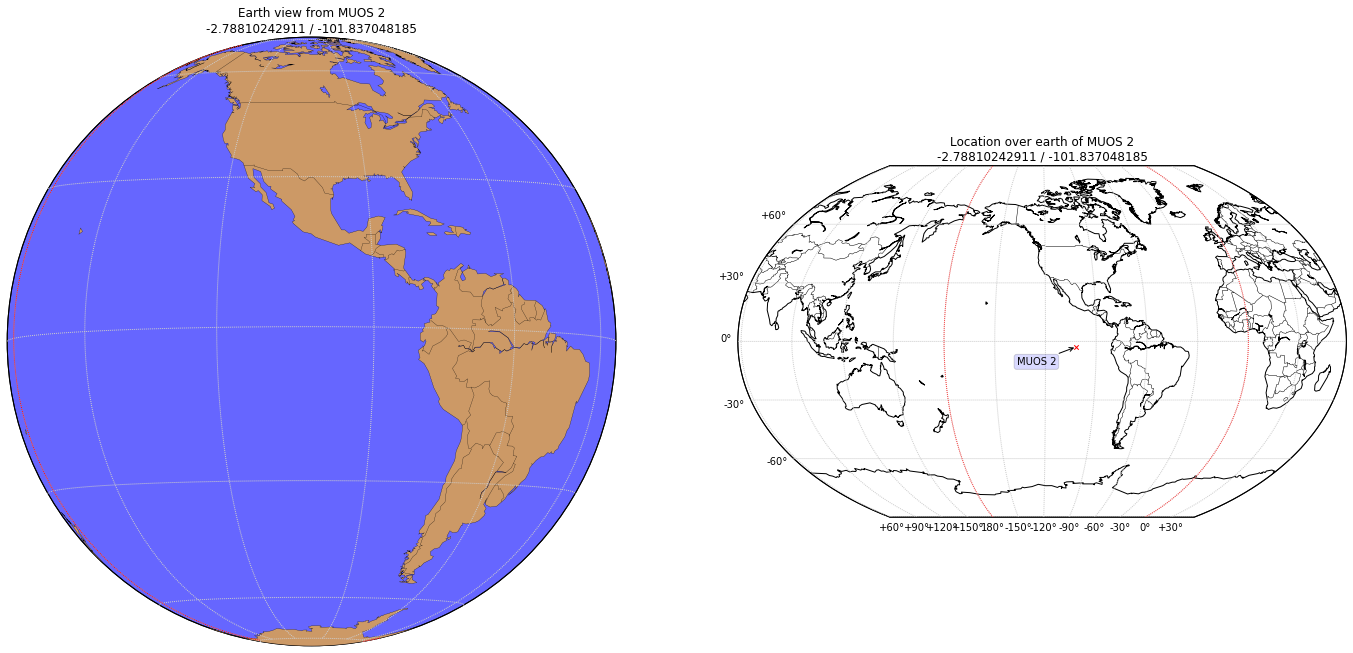

In [28]:
x = get_tle_by_name('MUOS 2', dbx)
x = tle2sky(tle=[x['TLE_LINE0'],x['TLE_LINE1'],x['TLE_LINE2']], current_time=current_time)

In [17]:
compute_next_orbital_track(x, start_time=current_time)

NameError: name 'x' is not defined

Calculating position at 2016-11-03 22:59:40.999999


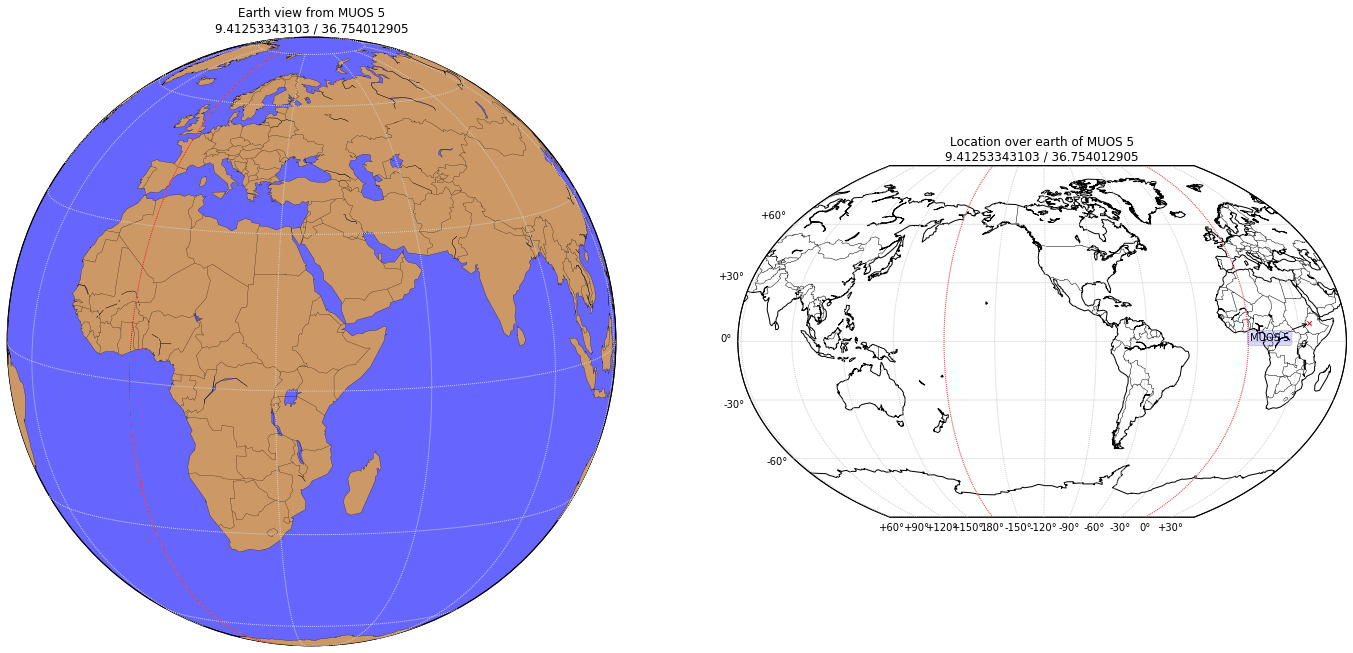

<ephem.EarthSatellite 'MUOS 5' at 0x7ff57c78e5d0>

In [18]:
tle2sky(eph=m5eph, current_time=current_time)

Calculating track starting at 2016-11-03 22:59:40.999999


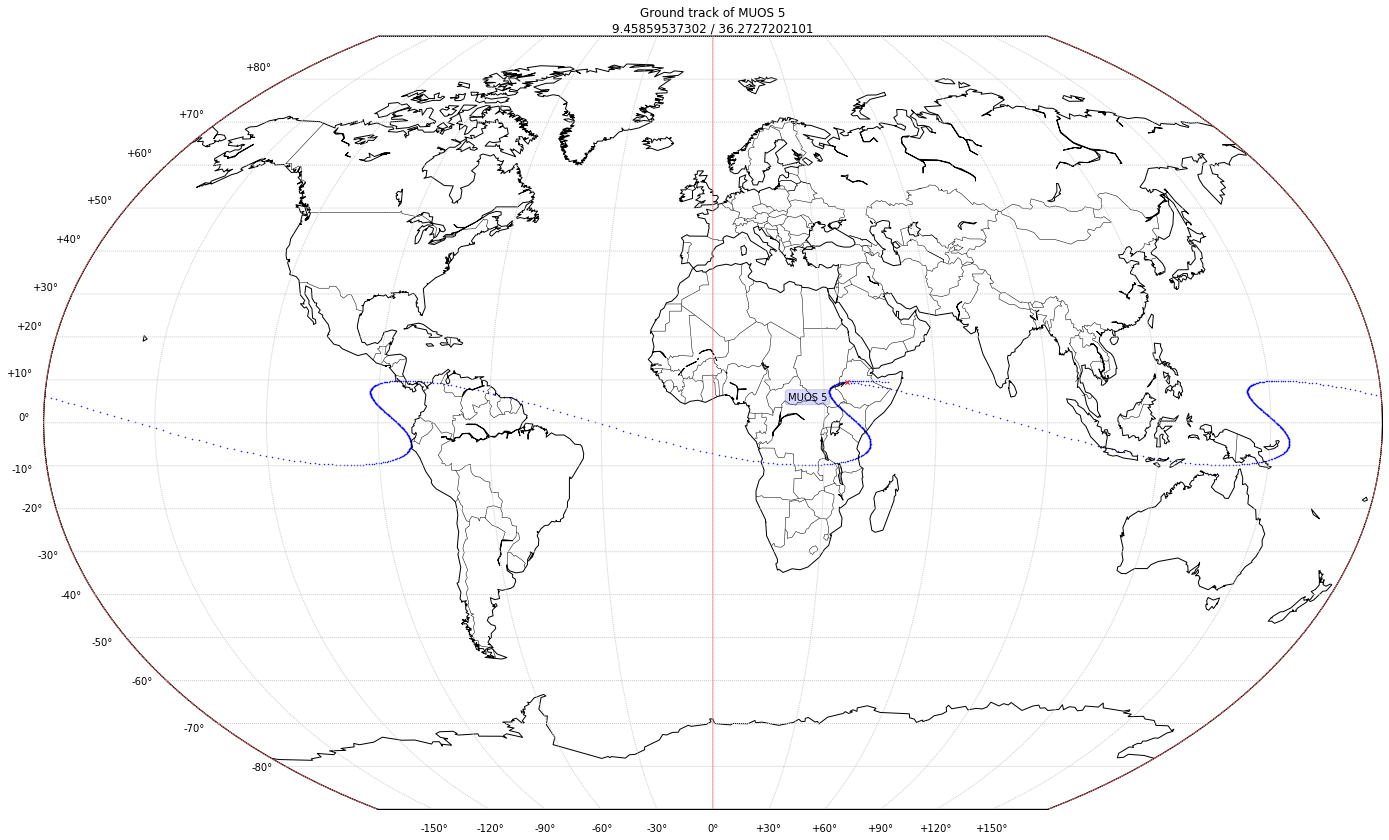

In [19]:
compute_next_orbital_track(m5eph, numsteps=256, orbits=3, start_time=current_time)

In [13]:
def get_tle_by_name(name, dbx=dbx):
    t = dbx['classified'].find({'ORIGINATOR':'SEESAT', 'OBJECT_NAME':name}, {'TLE_LINE0':True, 'TLE_LINE1':True, 'TLE_LINE2':True, 'OBJECT_NAME':True}).limit(1)
    if t.count() == 0:
        return None
    t = list(t)[0]
    for f in ['OBJECT_NAME', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2']:
        t[f] = str(t[f])
    return t

def get_eph_obj_by_name(name, dbx=dbx):
    tle = get_tle_by_name(name, dbx)
    if tle is None:
        return None
    return ephem.readtle(tle['TLE_LINE0'], tle['TLE_LINE1'], tle['TLE_LINE2'])

tle = get_tle_by_name('Mentor 7')
m7eph = get_eph_obj_by_name('Mentor 7')
print(tle)
print(m7eph)

{u'TLE_LINE0': 'Mentor 7', u'TLE_LINE2': '2 41584   7.4754 353.6914 0039264  47.5189 312.7801  1.00270000    02', u'OBJECT_NAME': 'Mentor 7', u'_id': ObjectId('57d33077443364329d3c4a4a'), u'TLE_LINE1': '1 41584U 16036A   16225.80348816 0.00000000  00000-0  00000-0 0    05'}
<ephem.EarthSatellite 'Mentor 7' at 0x7f568f955030>


In [14]:
m5eph = get_eph_obj_by_name('MUOS 5')

In [20]:
tle

{u'OBJECT_NAME': 'Mentor 7',
 u'TLE_LINE0': 'Mentor 7',
 u'TLE_LINE1': '1 41584U 16036A   16167.96105997  .00000000  00000-0  00000-0 0    08',
 u'TLE_LINE2': '2 41584   7.5055 353.7008 0046333  41.2140 319.1375  1.00195548    05',
 u'_id': ObjectId('57aa41dd4a85183435406c74')}